<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/skeleton_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.__version__
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.13.1+cu116 True


In [3]:
!pip show pyyaml
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' &> /dev/null

Name: PyYAML
Version: 6.0
Summary: YAML parser and emitter for Python
Home-page: https://pyyaml.org/
Author: Kirill Simonov
Author-email: xi@resolvent.net
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: 
Required-by: albumentations, bokeh, dask, distributed, fastai, PyDrive


In [4]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("person_keypoints_train", {}, "/content/drive/MyDrive/Dataset/project_aspine/annotations/person_keypoints_default.json", "/content/drive/MyDrive/Dataset/project_aspine/images")

In [6]:
keypoint_names = ["nose","mouse"]
keypoint_flip_map = []
MetadataCatalog.get("person_keypoints_train")
keypoint_connection_rules = [('nose', 'mouse', (102, 204, 255)),]

In [7]:
from detectron2.data import MetadataCatalog
MetadataCatalog.get("person_keypoints_train").keypoint_connection_rules = keypoint_connection_rules
MetadataCatalog.get("person_keypoints_train").thing_classes = ["nosemouse"]
MetadataCatalog.get("person_keypoints_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("person_keypoints_train").keypoint_names = keypoint_names
MetadataCatalog.get("person_keypoints_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("person_keypoints_train").evaluator_type="coco"

In [8]:
MetadataCatalog.get("person_keypoints_train")

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/Dataset/project_aspine/images', json_file='/content/drive/MyDrive/Dataset/project_aspine/annotations/person_keypoints_default.json', keypoint_connection_rules=[('nose', 'mouse', (102, 204, 255))], keypoint_flip_map=[], keypoint_names=['nose', 'mouse'], name='person_keypoints_train', thing_classes=['nosemouse'], thing_dataset_id_to_contiguous_id={1: 0})

In [9]:
dataset_dicts = DatasetCatalog.get("person_keypoints_train")
dataset_dicts

[02/18 13:58:34 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Dataset/project_aspine/annotations/person_keypoints_default.json takes 1.45 seconds.
[02/18 13:58:34 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/drive/MyDrive/Dataset/project_aspine/annotations/person_keypoints_default.json


[{'file_name': '/content/drive/MyDrive/Dataset/project_aspine/images/000000010707.jpg',
  'height': 480,
  'width': 640,
  'image_id': 1,
  'annotations': [{'iscrowd': 0,
    'bbox': [362.47, 340.14, 9.32, 23.06],
    'keypoints': [372.29, 340.64, 2, 362.97, 363.7, 2],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [432.16, 79.03, 51.04, 3.44],
    'keypoints': [432.66, 82.97, 2, 483.7, 79.53, 2],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>},
   {'iscrowd': 0,
    'bbox': [279.43, 278.96, 54.67, 12.45],
    'keypoints': [279.93, 279.46, 2, 334.6, 291.91, 2],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]},
 {'file_name': '/content/drive/MyDrive/Dataset/project_aspine/images/000000009448.jpg',
  'height': 640,
  'width': 551,
  'image_id': 2,
  'annotations': [{'iscrowd': 0,
    'bbox': [245.21, 308.38, 50.92, 231.38],
    'keypoints': [245.71, 308.88, 2, 296.63, 540.26, 2],
    'category_id': 0,
    'bbox_mo

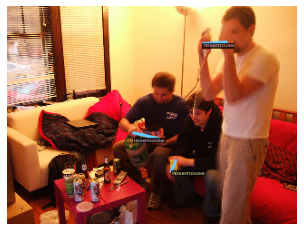

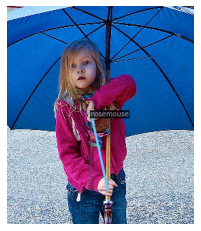

In [10]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

hands_metadata = MetadataCatalog.get("person_keypoints_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 2):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=hands_metadata, scale=0.5)    
  vis = visualizer.draw_dataset_dict(d)
  cv2_imshow(vis.get_image()[:, :, ::-1])

In [11]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# cfg.MODEL.DEVICE = "cpu"


cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("person_keypoints_train",)


#cfg.DATASETS.TEST = ("hand_test",)  #Dataset 'hand_test' is empty in my case
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 100   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   #128   # faster, and good enough for this toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # person
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 2
# cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((2, 1), dtype=float).tolist()


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/18 13:58:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:05, 18.9MB/s]                           


[02/18 13:58:46 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[02/18 13:58:46 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.keypoint_head.conv_fcn1.{bias, weight}
roi_heads.keypoint_head.conv_fcn2.{bias, weight}
roi_heads.keypoint_head.conv_fcn3.{bias, weight}
roi_heads.keypoint_head.conv_fcn4.{bias, weight}
roi_heads.keypoint_head.conv_fcn5.{bias, weight}
roi_heads.keypoint_head.conv_fcn6.{bias, weight}
roi_heads.keypoint_head.conv_fcn7.{bias, weight}
roi_heads.keypoint_head.c

[02/18 13:58:46 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.8/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Trigg

[02/18 13:59:09 d2.utils.events]:  eta: 0:00:31  iter: 19  total_loss: 8.124  loss_cls: 0.2439  loss_box_reg: 7.481e-05  loss_keypoint: 7.036  loss_rpn_cls: 0.6982  loss_rpn_loc: 0.1624  time: 0.3862  last_time: 0.3272  data_time: 0.0268  last_data_time: 0.0155   lr: 4.7703e-05  max_mem: 2508M
[02/18 13:59:17 d2.utils.events]:  eta: 0:00:23  iter: 39  total_loss: 3.565  loss_cls: 0.1441  loss_box_reg: 0.02787  loss_keypoint: 2.441  loss_rpn_cls: 0.6458  loss_rpn_loc: 0.1404  time: 0.3889  last_time: 0.4368  data_time: 0.0158  last_data_time: 0.0065   lr: 9.7653e-05  max_mem: 2508M
[02/18 13:59:25 d2.utils.events]:  eta: 0:00:15  iter: 59  total_loss: 4.027  loss_cls: 0.1472  loss_box_reg: 0.01785  loss_keypoint: 3.343  loss_rpn_cls: 0.5391  loss_rpn_loc: 0.09201  time: 0.3875  last_time: 0.4066  data_time: 0.0141  last_data_time: 0.0041   lr: 0.0001476  max_mem: 2508M
[02/18 13:59:32 d2.utils.events]:  eta: 0:00:07  iter: 79  total_loss: 3.806  loss_cls: 0.1024  loss_box_reg: 0.01933  

In [12]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

#We are using the pre-trained Detectron2 model, as shown below.
cfg = get_cfg()

# load the pre trained model from Detectron2 model zoo
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold

predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/drive/MyDrive/Dataset/project_aspine/images/000000009448.jpg")


[02/18 13:59:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


backbone.res2.0.conv1.norm.{bias, weight}
backbone.res2.0.conv1.weight
backbone.res2.0.conv2.norm.{bias, weight}
backbone.res2.0.conv2.weight
backbone.res2.0.conv3.norm.{bias, weight}
backbone.res2.0.conv3.weight
backbone.res2.0.shortcut.norm.{bias, weight}
backbone.res2.0.shortcut.weight
backbone.res2.1.conv1.norm.{bias, weight}
backbone.res2.1.conv1.weight
backbone.res2.1.conv2.norm.{bias, weight}
backbone.res2.1.conv2.weight
backbone.res2.1.conv3.norm.{bias, weight}
backbone.res2.1.conv3.weight
backbone.res2.2.conv1.norm.{bias, weight}
backbone.res2.2.conv1.weight
backbone.res2.2.conv2.norm.{bias, weight}
backbone.res2.2.conv2.weight
backbone.res2.2.conv3.norm.{bias, weight}
backbone.res2.2.conv3.weight
backbone.res3.0.conv1.norm.{bias, weight}
backbone.res3.0.conv1.weight
backbone.res3.0.conv2.norm.{bias, weight}
backbone.res3.0.conv2.weight
backbone.res3.0.conv3.norm.{bias, weight}
backbone.res3.0.conv3.weight
backbone.res3.0.shortcut.norm.{bias, weight}
backbone.res3.0.shortcut.w

In [13]:
outputs = predictor(im)
outputs

{'instances': Instances(num_instances=0, image_height=640, image_width=551, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}

In [14]:
import matplotlib.pyplot as plt
im = cv2.imread("/content/drive/MyDrive/Dataset/project_aspine/images/000000009448.jpg")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');


v = Visualizer(im[:, :, ::-1],
  metadata=hands_metadata, 
  scale=0.8, 
  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
outputs["instances"].to("cpu")

# o = outputs["instances"]
# #Create new class, boxes, scores & masks
# classes = o.pred_classes[idxofClass]
# scores = o.scores[idxofClass]
# boxes = o.pred_boxes[idxofClass]
# #masks = o.pred_masks[idxofClass]

# #Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
# obj = detectron2.structures.Instances(image_size=(480, 640))

# obj.set('pred_classes', classes)
# obj.set('scores', scores)
# obj.set('pred_boxes', boxes)

# obj

Instances(num_instances=0, image_height=640, image_width=551, fields=[pred_boxes: Boxes(tensor([], size=(0, 4))), scores: tensor([]), pred_classes: tensor([], dtype=torch.int64)])